<a href="https://colab.research.google.com/github/mcmejiag14/Deep-Learning/blob/main/Problem_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [31]:
!ls "/content/drive/My Drive/Colab Notebooks"

'a0=26 p=11'	    'a0=48 . p=11'		   'Problem 3 Homework 2.ipynb'
'a0=30.ipynb'	    'a0=50 p=11'		   'Problem 3 .ipynb'
'a0=30 p=13.ipynb'   Copy_of_GAN_MNIST_Data.ipynb   Untitled
'a0=32.ipynb'	    'Hecke Operator 7'		   'Untitled (1)'
'a0=32 p=13.ipynb'  'Hecke Operator p=5 prime 7'   'Untitled (2)'


In [32]:
#Importing data
import torch ## we need torch and torchvision
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose ## and we need transform
from torchvision.datasets import MNIST

mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])) ## Here we get the data, we can transform the data  to a tensor and normalized the vectors with mean 0.5
              ## and standard deviation 0.5

We are going to implement the generate and the discriminant. The task of the generate is generate fake samples  givne some random noise and the discriminator usually tries to detemrine if the given sample is real or not. 

Then the geneating will be train with some epochs and the discrminator as well and then it will be repeated. The dsicriminator should not be able to identify the fake one if the generator works perfectly.

In [33]:
## Here we are going to do some investigation of the pixel values.
#Note that pixel values were transformed from the range [0, 1] to the range [-1, 1].
#Look at sample tensor values.
img, label = mnist[0] ##if we take the first obsevation we will have the labels
print('Label: ', label)
print(img[:,10:15,10:15]) ## What are the values for the pixel. 
torch.min(img), torch.max(img) ## All images will be transform 1 or -1 after normalization.

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

In [34]:
img.size(dim=1)

28

In [35]:
img.size()

torch.Size([1, 28, 28])

In [36]:
## To see the original image we need to denormalize, so we use denorm to do it, we create the function with the argument x
# function to denormalize and view the images. 
# This function will also be useful for viewing the generated images.
def denorm(x):
    out = (x + 1) / 2 ## we create this function, which depending if x is 1 or -1 will give us the output 0 or 1
    return out.clamp(0, 1)

Label: 5


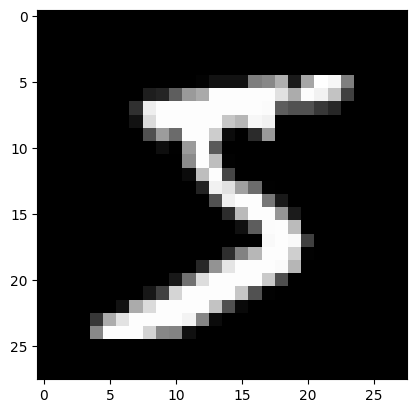

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
## Now we can use the above to build a particular image
img_norm = denorm(img) ## We use the denom function and the function img
plt.imshow(img_norm[0], cmap='gray') ## we use this to visualize the label
print('Label:', label)
## The image is not perfect, but is what we could see of the pixel values, this is kind of basic investigation about the datase

In [38]:
#Create a dataloader to load the images in batches.
from torch.utils.data import DataLoader ### We need this and import the DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True) 

first batch
torch.Size([100, 1, 28, 28])
tensor([9, 9, 3, 1, 8, 9, 1, 7, 3, 5, 5, 7, 0, 8, 5, 3, 2, 4, 6, 3, 5, 7, 4, 8,
        2, 7, 6, 4, 4, 5, 1, 9, 8, 2, 2, 0, 4, 7, 2, 4, 4, 3, 7, 3, 6, 2, 2, 9,
        6, 1, 8, 7, 6, 7, 3, 9, 4, 8, 5, 9, 7, 9, 2, 7, 3, 4, 7, 6, 1, 1, 6, 9,
        5, 9, 1, 2, 0, 1, 1, 6, 8, 9, 5, 3, 1, 1, 3, 3, 3, 5, 0, 1, 8, 6, 6, 8,
        8, 3, 4, 4])


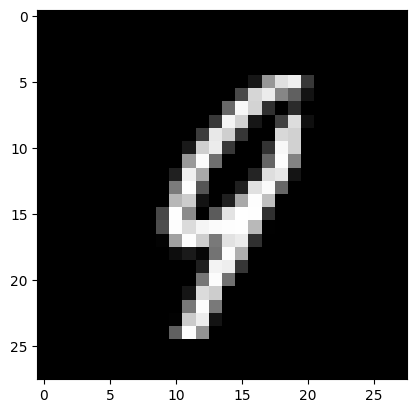

In [39]:
for img_batch, label_batch in data_loader:
    print('first batch') ## Here we could see how the first batch is going to work, with the shape
    print(img_batch.shape) ## The shape
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)  ## we can also print the label of the batch
    break 
   

In [40]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') ## We need to make sure that we are using GPU, Otherwise we will spend a lot of time runi¿ning the GAN MODEL
device

device(type='cuda')

In [101]:
#Discriminator Network  ## We are going to train the discriminator, so we need to create the discrimator neural network
image_size = 784 ## This image will be 28x28
hidden_size = 512 ## The number of hidden nodes

In [102]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.ReLU(), 
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()) 

## A simple neural network with just three linear  layer and the activation function will be ReLu for two of them and for one Sigmoid

In [103]:
# Move the discriminator model to the chosen device.
D.to(device);

In [104]:
# Genarator Network ## Now we are going to create the genaration
latent_size = 90 ## The latent size is the random noise that we are going to sample given distribution

In [107]:
## Here we are  going to create the neural network for the generator, we have the latentsiza and the hidden nodes same as in the discriminator
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size), ## Linear Layer with ReLu activation function, we can make sure that we have -1 or 1
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()) ## At the end your output size needs to be the same that the image size

In [108]:
G.to(device); ## We pass the generating to the Device

# Discriminator Training

Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

Here are the steps involved in training the discriminator.

We expect the discriminator to output 1 if the image was picked from the real MNIST dataset, and 0 if it was generated. 

We first pass a batch of real images, and compute the loss, setting the target labels to 1. 

Then, we generate a batch of fake images using the generator, pass them into the discriminator, and compute the loss, setting the target labels to 0. 

Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator (d_optimizer only affects the D.parameters())


In [109]:
criterion = nn.BCELoss() ## This is the Binary cross entropy function
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0001) ## We use the Adam optimizer with the learning rate 0.0002, we do it with D.parameters()

In [110]:
def reset_grad():  ## We create the reset function to the reset the gradient
    d_optimizer.zero_grad() ## We can reset the gradients when we do each batch
    g_optimizer.zero_grad()

def train_discriminator(images): ## We are going to introduce the train discrimator
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device) ## We create the real labels, we will have all ones
    fake_labels = torch.zeros(batch_size, 1).to(device) ## We create the  the fake labels, we will have all zeros
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels) ## We calculate the difference between the outputs and the real labels, we use the cross entropy
    real_score = outputs ## The real outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device) ## Here we calculate the loss for the fake images, we create some random values created from a normal distribution
    fake_images = G(z) ## We put this random values into the generator 
    outputs = D(fake_images) ## Get the outputs
    d_loss_fake = criterion(outputs, fake_labels) ## We use same cross entropy loss 
    fake_score = outputs ## all the ouputs score

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()  ## The training and get the return values
    
    return d_loss, real_score, fake_score



# Generator Training

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

We generate a batch of images using the generator, pass the into the discriminator.

We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator. 

We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images.


In [111]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002) ## We are going to use the sdam  optimize rof the G.parameters

In [112]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device) ## We create a random number generation of the same size of the latent size
    fake_images = G(z) 
    labels = torch.ones(batch_size, 1).to(device) ## we have the labels created
    g_loss = criterion(D(fake_images), labels) ## We calculate the g_loss

    # Backprop and optimize
    reset_grad()
    g_loss.backward() ## We called the backpropagation for the f loss
    g_optimizer.step()
    return g_loss, fake_images


# Training the Model

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model.


In [113]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)



Let's save a batch of real images that we can use for visual comparision while looking at the generated images.


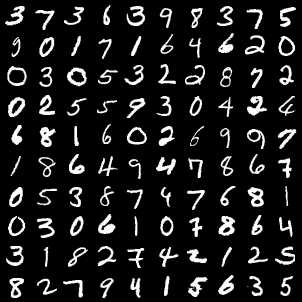

In [114]:
from IPython.display import Image
from torchvision.utils import save_image
## This are some real images
# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

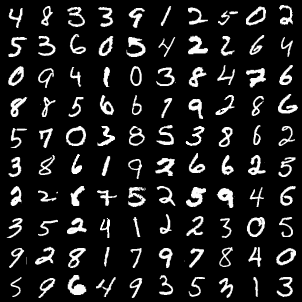

In [115]:
from IPython.display import Image
from torchvision.utils import save_image
## This are some real images
# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

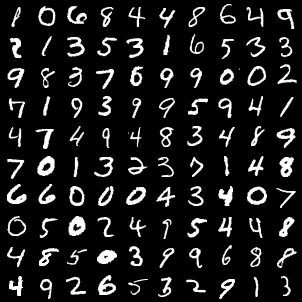

In [116]:
from IPython.display import Image
from torchvision.utils import save_image
## This are some real images
# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

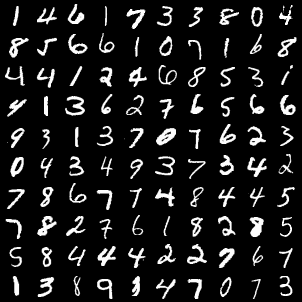

In [117]:
from IPython.display import Image
from torchvision.utils import save_image
## This are some real images
# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

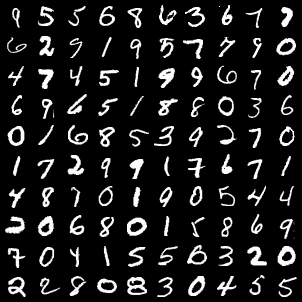

In [118]:
from IPython.display import Image
from torchvision.utils import save_image
## This are some real images
# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

 We can save a batch of generated images to disk at the end of every epoch. We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model.

Saving fake_images-0000.png


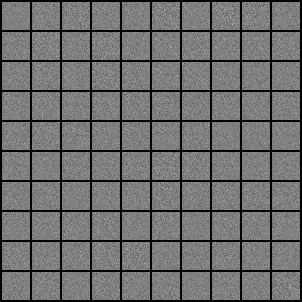

In [119]:
sample_vectors = torch.randn(batch_size, latent_size).to(device) ## a vector define from the normal distribution

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28) ## you are going to reshape into the same sise
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname) ## Save name
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

## We don't have anything in this particular image because we have not train the model yet 

# Training the GAN. 

In each epoch, we train the discriminator first, and then the generator. 

In [120]:
%%time

num_epochs = 300 ## The number of epochs need to be determine depending of the quality of the image
total_step = len(data_loader) ## we have the data 
d_losses, g_losses, real_scores, fake_scores = [], [], [], [] ## we are going to define some empy vectors 

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images) ## This is the returning values
        g_loss, fake_images = train_generator() ## This will be the training function of the generator
        
        # Inspect the losses ( We want to investigate how the values looks like)
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item()) ## We are going to get d score losses
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item()) ## The real score values
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)
    ##d_loss, is the  D(x) the average score for real data, D(g(z)) the average score for the fake data

Epoch [0/300], Step [200/600], d_loss: 0.1694, g_loss: 2.9078, D(x): 0.93, D(G(z)): 0.09
Epoch [0/300], Step [400/600], d_loss: 0.2613, g_loss: 3.1176, D(x): 0.91, D(G(z)): 0.15
Epoch [0/300], Step [600/600], d_loss: 0.1188, g_loss: 3.8228, D(x): 0.96, D(G(z)): 0.07
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.5602, g_loss: 3.8413, D(x): 0.82, D(G(z)): 0.18
Epoch [1/300], Step [400/600], d_loss: 0.3051, g_loss: 3.1005, D(x): 0.87, D(G(z)): 0.10
Epoch [1/300], Step [600/600], d_loss: 0.3203, g_loss: 2.4234, D(x): 0.89, D(G(z)): 0.15
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 1.4432, g_loss: 1.8082, D(x): 0.65, D(G(z)): 0.44
Epoch [2/300], Step [400/600], d_loss: 1.2690, g_loss: 1.3305, D(x): 0.84, D(G(z)): 0.56
Epoch [2/300], Step [600/600], d_loss: 0.4217, g_loss: 2.4588, D(x): 0.85, D(G(z)): 0.15
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.2301, g_loss: 3.4782, D(x): 0.90, D(G(z)): 0.07
Epoch [3/300], Step [400/6



Here's how the generated images look, after the 10th, 50th, 100th and 300th epochs of training.


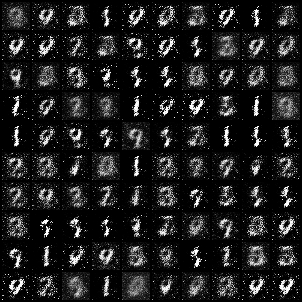

In [121]:
Image('./samples/fake_images-0015.png') ## This is after the 10 epoch, is not really able to get anything

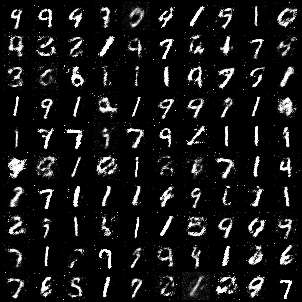

In [122]:
Image('./samples/fake_images-0060.png') ## Some of the numbers are visible

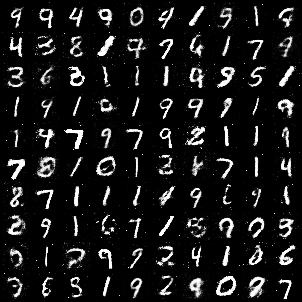

In [123]:
Image('./samples/fake_images-0100.png') ## This one is better

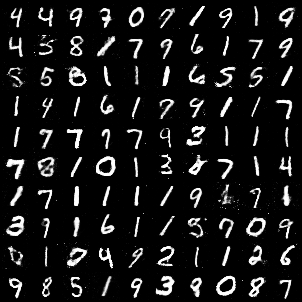

In [124]:
Image('./samples/fake_images-0300.png') ## This one is better than the others, the digits are more clear. The fake images are more closely to the real random values.
## This is an inspection of the fake data and the real data. Changing the number of epochs and doing some hyperparameters turning we could get a better improve version.

# Visualizing the Loss
we can see how the loss changes over time. Visualizing losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.

Text(0.5, 1.0, 'Losses')

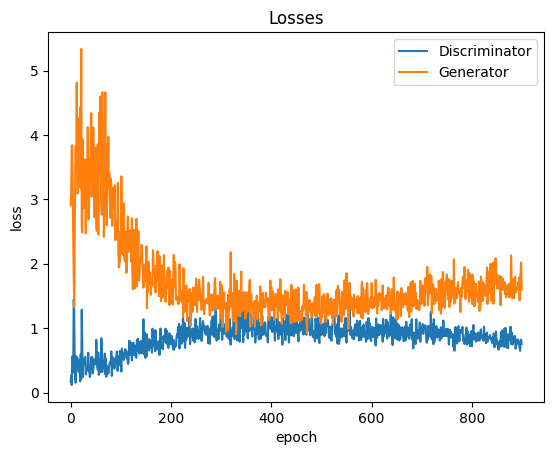

In [125]:
## The last thing is visualize the losses for generator and discriminator
### The generator needs to be improve
##Ideally when the generator goes down the discriminator needs to increase, because the discriminator needs to be able to identify the real images and the fake images.
plt.plot(d_losses, '-') ## Here we plot the discriminator loss
plt.plot(g_losses, '-') ## Here we plot the generator loss
plt.xlabel('epoch') ## Here we define the axis x, epochs
plt.ylabel('loss') ## Here we define the label y, loss
plt.legend(['Discriminator', 'Generator']) ## We plot both
plt.title('Losses') ## We define the tittle

## As you could see the generatos goes down as the number of epochs increase, while for the discrimator it keeps increasing at the certain level. 
## When this happend the discriminator will state at the same level, in this case you can get the training stop because the is not needed improvements.